<a href="https://colab.research.google.com/github/Nishant-codex/rnn_flip_flops/blob/master/notebooks/flip_flop_lif%2BMDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Leaky Integrate and Fire using TF cell
This notebook contains an example for training 3 bit Flip-FLop on LIF cell based Bellec et.al 


In [ ]:
!git clone https://github.com/Nishant-codex/LSNN-official.git

fatal: destination path 'LSNN-official' already exists and is not an empty directory.


In [ ]:
import numpy as np
import os
import absl
%tensorflow_version 1.x
import tensorflow as tf
import pylab 
from tensorflow.python.ops import parallel_for as pfor
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

import numpy.random as nrand 
import pickle
from FixedPointStore import FixedPointStore
from FixedPointSearch import FixedPointSearch
import pickle
import tables
import time
from time import time

from AdaptiveGradNormClip import AdaptiveGradNormClip
from AdaptiveLearningRate import AdaptiveLearningRate
from collections import namedtuple

LIFStateTuple = namedtuple('LIFStateTuple', ('v', 'z', 'i_future_buffer', 'z_buffer'))
ALIFStateTuple = namedtuple('ALIFStateTuple', ('z','v','b','i_future_buffer','z_buffer'))

import sys 
sys.path.insert(0,'/content/LSNN-official/')
sys.path.insert(0,'/content/LSNN-official/bin')

import lsnn.spiking_models as lsnn
from lsnn.toolbox.tensorflow_einsums.einsum_re_written import einsum_bij_jk_to_bik

# from lsnn.toolbox.rewiring_tools import rewiring_optimizer_wrapper
from lsnn.spiking_models import tf_cell_to_savable_dict, exp_convolve #ALIF, LIF
from lsnn.toolbox.rewiring_tools import weight_sampler, rewiring_optimizer_wrapper

import os
from time import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from lsnn.toolbox.file_saver_dumper_no_h5py import save_file, get_storage_path_reference
from tutorial_sequential_mnist_plot import update_mnist_plot

from lsnn.spiking_models import tf_cell_to_savable_dict, exp_convolve, ALIF, LIF
from lsnn.toolbox.tensorflow_utils import tf_downsample
import json
from tensorflow.examples.tutorials.mnist import input_data


TensorFlow 1.x selected.
No display found. Using non-interactive Agg backend.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
from seq_mnist_final import RNN_MNIST

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [ ]:
rnn_obj = RNN_MNIST()
rnn_obj.train()




Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Iteration 0, epoch 0 validation accuracy 0.0938 
Iteration 0, epoch 0 training accuracy 0.0859 loss 2.3
Iteration 100, epoch 0 training accuracy 0.0859 loss 2.53e+36
Iteration 200, epoch 0 training accuracy 0.156 loss 2.17e+36
Iteration 300, epoch 0 training accuracy 0.109 loss 2.64e+36
Iteration 400, epoch 0 training accuracy 0.0703 loss 2.53e+36
Iteration 500, epoch 1 training accuracy 0.109 loss 2.44e+36
Iteration 600, epoch 1 training accuracy 0.0859 loss 2.43e+36
It

KeyboardInterrupt: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
 class FlipFlop:
#Hyperparameters
    
    hyp_dict = \
    {'time' : 500,
    'bits' : 3 ,
    'num_steps' : 6,
    'batch_size' : 64,
    'neurons' : 64 ,
    'num_classes' : 2,
    'p': 0.2,
    'learning_rate' :0.01,
    'decay_steps': 100,
    'c_type':'UGRNN'
    }
    '''
    Architectures: 
    Vanilla, UG-RNN, GRU, LSTM
    
    Activation: 
    Tanh, relu
    
    Num_units:
    64, 128, 256 
    
    L2 regularization: 
    1e-5, 1e-4, 1e-3, 1e-2
    '''
    def __init__(self,
        time = hyp_dict['time'],
        bits = hyp_dict['bits'],
        num_steps = hyp_dict['num_steps'],
        batch_size = hyp_dict['batch_size'],
        neurons = hyp_dict['neurons'],
        num_classes = hyp_dict['num_classes'],
        learning_rate = hyp_dict['learning_rate'],
        p = hyp_dict['p'],
        c_type = hyp_dict['c_type'],
        l2 = 0.01,
        decay_steps = 0,
        _seed = 400,
        **hps):
      
        self.seed = _seed
        self.time = time
        self.new_lr = 0
        self.hps = hps
        self.cell = None
        self.activation = 'tanh'
        self.lr_update = 0
        self.bits = bits
        self.model = None
        self.fps = None
        self.alr_hps = {}#{'initial_rate': 1.0, 'min_rate': 1e-5}
        self.grad_global_norm = 0
        self.grad_norm_clip_val = 0
        self.dtype = tf.float32
        self.opt = 'norm'
        self.l2_loss = l2
        self.decay_steps = decay_steps
        # self.adaptive_learning_rate = AdaptiveLearningRate(**self.alr_hps)
        # self.adaptive_grad_norm_clip = AdaptiveGradNormClip(**{})
        self.num_steps = num_steps
        self.num_steps =num_steps 
        self.batch_size = batch_size 
        self.neurons = neurons 
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.p = p  
        self.graph = 0
        self.chkpt = None
        self.c_type = c_type    
        self.sess = 0
        self.test_data = []

        np.random.seed(self.seed)

    def flip_flop(self, p = 0, plot=False):

      unsigned_inp = np.random.binomial(1,p,[self.batch_size,self.time//10,self.bits])
      unsigned_out = 2*np.random.binomial(1,0.5,[self.batch_size,self.time//10,self.bits]) -1 



      inputs = np.multiply(unsigned_inp,unsigned_out)
      inputs[:,0,:] = 1
      inputs = np.repeat(inputs,10,axis=1)
      output = np.zeros_like(inputs)
      for trial_idx in range(self.batch_size):
          for bit_idx in range(self.bits):
              input_ = np.squeeze(inputs[trial_idx,:, bit_idx])
              t_flip = np.where(input_ != 0)
              for flip_idx in range(np.size(t_flip)):
                  # Get the time of the next flip
                  t_flip_i = t_flip[0][flip_idx]

                  '''Set the output to the sign of the flip for the
                  remainder of the trial. Future flips will overwrite future
                  output'''
                  output[trial_idx, t_flip_i:, bit_idx] = \
                      inputs[trial_idx, t_flip_i, bit_idx]

      
      if plot:
        fig, ax = plt.subplots(3)

        ax[0].plot(inputs[0,:,0])
        ax[0].plot(output[0,:,0])
        ax[0].set_xlabel("time")
        ax[0].set_ylabel("Bit 0")
        ax[1].plot(inputs[0,:,1])
        ax[1].plot(output[0,:,1])
        ax[1].set_xlabel("time")
        ax[1].set_ylabel("Bit 1")
        ax[2].plot(inputs[0,:,2])
        ax[2].plot(output[0,:,2])
        ax[2].set_xlabel("time")
        ax[2].set_ylabel("Bit 2")
        plt.show()


      return {'inputs': inputs, 'output': output}

    
    def data_batches(self,num_batches,seed=None, save =False):
      batch_list = []
      if seed is not None:
        # self.seed = seed
        np.random.seed(seed)
      t1 = round(time.time()//1e6)
      total = 0
      for i in range(num_batches):

        single_batch = self.flip_flop()
        batch_list.append(single_batch)
        t2 = round((time.time()-t1)//1e6, 3)
        total +=t2
        # if i ==0:
        # print('time to generate' + 'batch'+str(i)+ 'is ', total)
        t1 = t2
        
      self.save_data(batch_list)
          # del(batch_list)
          # batch_list = []


      print('total time is %f', total)
      return batch_list
    def setup_optimizer(self, loss,rewiring_connectivity=None, temperature= None):

      if self.c_type == 'LIF' or self.c_type == 'ALIF':
        global_step = tf.Variable(0, dtype=tf.int32, trainable=False)
        learning_rate = tf.Variable(self.hps['lrate'], dtype=tf.float32, trainable=False)
        decay_learning_rate_op = tf.assign(learning_rate, learning_rate * self.hps['decay'])  # Op to decay learning rate

        loss = loss

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        l1 = 1e-01

        # if 0 < rewiring_connectivity:

        #     train_op = rewiring_optimizer_wrapper(optimizer, loss, learning_rate, l1, temperature,
        #                                             rewiring_connectivity,
        #                                             global_step = global_step,
        #                                             var_list=tf.trainable_variables())
        # else:
        train_op = optimizer.minimize(loss=loss, global_step=global_step)
    #   # else:
    #   self.global_step = tf.Variable(0, trainable=False)
    #   decay = tf.train.exponential_decay(self.hps['lrate'],self.global_step,1000,self.hps['decay'])
    # #   optimizer = tf.train.MomentumOptimizer(decay,self.hps['moment'],use_nesterov=False)
    #   # optimizer = tf.train.AdamOptimizer(learning_rate=self.hps['lrate'])
    #   # optimizer = tf.train.AdamOptimizer(learning_rate=decay,)
    #   # gradients, variables = zip(*optimizer.compute_gradients(loss,tf.trainable_variables()))
    #   # gradients = [
    #   #     None if gradient is None else tf.clip_by_norm(gradient, hps['norm'])
    #   #     for gradient in gradients]
    #   # train_op = optimizer.apply_gradients(zip(gradients, variables))
    #   train_op = optimizer.minimize(loss,global_step = self.global_step)

      return train_op, decay_learning_rate_op
      
    def save_data(self, array):
      dir_name = os.getcwd()+'/data_'+str(self.seed)+'/'
      if not os.path.exists(os.path.dirname(dir_name)):
        os.makedirs(os.path.dirname(dir_name))

      filename  = dir_name+'data.npy'   
      f =  open(filename,'wb')
      np.save(f, np.array(array) ,allow_pickle=True)

    def restore_data(self, path):
      file = open(path,'rb')
      restore_data = np.load(file, allow_pickle=True)
      # file.close()
      # data = pickle.loads(restore_data,encoding='latin1')
      return restore_data

    def reset_graph(self):
        if 'sess' in globals() and self.sess:
            self.sess.close()
        tf.reset_default_graph()
    def is_lstm(self,x):
      if isinstance(x, tf.nn.rnn_cell.BasicLSTMCell):

        return True
      if isinstance(x, tf.nn.rnn_cell.LSTMStateTuple):
        return True

      return False

    def unroll_LSTM(self,lstm_cell, inputs, initial_state):

      assert (self.is_lstm(lstm_cell)),('lstm_cell is not an LSTM.')
      assert (self.is_lstm(initial_state)),('initial_state is not an LSTMStateTuple.')

      ''' Add ops to the graph for getting the complete LSTM state
      (i.e., hidden and cell) at every timestep.'''
      n_time = inputs.shape[1].value
      hidden_list = []
      cell_list = []

      prev_state = initial_state

      for t in range(n_time):

          input_ = inputs[:,t,:]

          _, state = lstm_cell(input_, prev_state)

          hidden_list.append(state.h)
          cell_list.append(state.c)
          prev_state = state

      c = tf.stack(cell_list, axis=1)
      h = tf.stack(hidden_list, axis=1)

      return tf.nn.rnn_cell.LSTMStateTuple(c=c, h=h)    
    def setup_model(self):
      
      self.reset_graph()
      x = tf.placeholder(tf.float32, [self.batch_size, self.time, self.bits], name='input_placeholder')
      y = tf.placeholder(tf.float32, [self.batch_size, self.time, self.bits], name='labels_placeholder')


      if self.c_type == 'Vanilla':
        if self.activation == 'tanh':
          self.cell = tf.nn.rnn_cell.BasicRNNCell(self.neurons,reuse=tf.AUTO_REUSE, activation=tf.nn.tanh)
        else:
          self.cell = tf.nn.rnn_cell.BasicRNNCell(self.neurons,reuse=tf.AUTO_REUSE, activation=tf.nn.relu)

      if self.c_type == 'GRU':
        if self.activation == 'tanh':
          self.cell = tf.nn.rnn_cell.GRUCell(self.neurons,reuse=tf.AUTO_REUSE, activation=tf.nn.tanh)
        else:
          self.cell = tf.nn.rnn_cell.GRUCell(self.neurons,reuse=tf.AUTO_REUSE, activation=tf.nn.relu)

      if self.c_type == 'UGRNN':
        if self.activation == 'tanh':
          self.cell = tf.contrib.rnn.UGRNNCell(self.neurons,reuse=tf.AUTO_REUSE, activation=tf.nn.tanh)
        else:
          self.cell = tf.contrib.rnn.UGRNNCell(self.neurons,reuse=tf.AUTO_REUSE, activation=tf.nn.relu)

      if self.c_type == 'LSTM':
        if self.activation == 'tanh':
          self.cell = tf.nn.rnn_cell.BasicLSTMCell(self.neurons,reuse=tf.AUTO_REUSE,state_is_tuple=True, activation=tf.nn.tanh)
        else:
          self.cell = tf.nn.rnn_cell.BasicLSTMCell(self.neurons,reuse=tf.AUTO_REUSE,state_is_tuple=True, activation=tf.nn.relu)
      ##
      FLAGS = tf.app.flags.FLAGS

      beta= 1.8
      # to solve a task successfully we usually set tau_a to be close to the expected delay / memory length needed
      tau_a = 150
      tau_v = 20
      dt = 1
      thr= 0.01
      learning_rate = 1e-2
      n_regular = self.hps['n_regular']

      n_adaptive = self.hps['adaptive']
      lr_decay = 0.8
      reg = 1e-1
      rewiring_temperature = 0.
      proportion_excitatory= 0.8
      n_in = 3

      rewiring_connectivity =.12
      l1 = 1e-2
      dampening_factor = 0.3
      neuron_sign = True
      n_delay = 1
      n_ref = 0
      # Sign of the neurons
      if 0 < rewiring_connectivity and neuron_sign:
        n_excitatory_in = int(proportion_excitatory * n_in) + 1
        n_inhibitory_in = n_in - n_excitatory_in
        print('Inhibitory num ',n_inhibitory_in)
        in_neuron_sign = np.concatenate([-np.ones(n_inhibitory_in), np.ones(n_excitatory_in)])
        np.random.shuffle(in_neuron_sign)


        n_excitatory = int(proportion_excitatory * (n_regular + n_adaptive)) + 1
        n_inhibitory = n_regular + n_adaptive - n_excitatory
        rec_neuron_sign = np.concatenate([-np.ones(n_inhibitory), np.ones(n_excitatory)])
      else:
          if not (neuron_sign == False): print(
              'WARNING: Neuron sign is set to None without rewiring but sign is requested')
          in_neuron_sign = None
          rec_neuron_sign = None

      if self.c_type == 'LIF':
        
        self.cell = lsnn.LIF(self.bits,
                             self.neurons,
                             tau=tau_v, 
                             thr = thr, 
                             rewiring_connectivity=rewiring_connectivity,
                             in_neuron_sign = in_neuron_sign,
                             dampening_factor = dampening_factor,
                             rec_neuron_sign=rec_neuron_sign,
                             n_refractory = n_ref,
                             n_delay = n_delay,
                             )
      if self.c_type == 'ALIF':
        beta = np.concatenate([np.zeros(n_regular), np.ones(n_adaptive) * beta])

        self.cell = lsnn.ALIF(n_in=self.bits, 
                              n_rec=n_regular + n_adaptive, 
                              tau=tau_v, 
                              n_delay=n_delay,
                              n_refractory=n_ref, 
                              dt=1, tau_adaptation=tau_a, 
                              beta=beta, 
                              thr=thr,
                              rewiring_connectivity=rewiring_connectivity,
                              in_neuron_sign=in_neuron_sign, rec_neuron_sign=rec_neuron_sign,
                              dampening_factor=dampening_factor,
                              )
      init_state = self.cell.zero_state(self.batch_size, dtype=tf.float32)
      if self.c_type == 'LSTM':
        rnn_outputs = self.unroll_LSTM(self.cell,x,init_state)
        hiddens = rnn_outputs.h
      elif self.c_type == 'LIF':
          z = []
          v = []
          states = []
          state_inst = init_state
          for t_idx in range(self.time):

            z_inst, state_inst = self.cell(x[:,t_idx,:],state_inst)
            z.append(z_inst)
            v.append(state_inst.v)
            states.append(state_inst)
      elif self.c_type == 'ALIF':
            z = []
            v = []
            bias = []
            states = []
            state_inst = init_state
            for t_idx in range(self.time):

              out, state_inst = self.cell(x[:,t_idx,:],state_inst)
              z_,v_,b_ = out
              z.append(z_)
              v.append(v_)
              bias.append(b_)
              states.append(state_inst)

      else:
        rnn_outputs, final_state = tf.nn.dynamic_rnn(self.cell, x, initial_state=init_state,)

        hiddens = rnn_outputs
      """
      rnn_outputs gives out rnn hidden states ht which is of the size [batch_size, timestep, neurons]
    
      """

      scale = 1.0 / np.sqrt(self.neurons)
      W = np.multiply(scale,np.random.randn(self.neurons, self.bits))
      b = np.zeros(self.bits)
      # with tf.variable_scope('losses',reuse=tf.AUTO_REUSE):
      #     W = tf.get_variable('W', [self.neurons , self.bits])
      #     b = tf.get_variable('b', [self.bits], initializer=tf.constant_initializer(0.0))
      z = tf.stack(z,axis=1)
      v = tf.stack(v,axis=1)
      bias = tf.stack(bias,axis=1)
      
      # z = tf.convert_to_tensor(z)
      psp_decay = np.exp(-dt / tau_v)  # output layer psp decay, chose value between 15 and 30ms as for tau_v
      psp = exp_convolve(z, decay=psp_decay)
      # n_neurons =  self.neurons #z.get_shape()[2]
      # n_output_symbols = self.bits
      # # Define the readout weights
      # if 0 < rewiring_connectivity:
      #     w_out, w_out_sign, w_out_var, _ = weight_sampler(n_regular + n_adaptive, 
      #                                                      n_output_symbols,
      #                                                      rewiring_connectivity,
      #                                                      neuron_sign=rec_neuron_sign)
      # else:
      #     w_out = tf.get_variable(name='out_weight', shape=[n_neurons, n_output_symbols])
      # b_out = tf.get_variable(name='out_bias', shape=[n_output_symbols], initializer=tf.zeros_initializer())

      # # Define the loss function

      with tf.variable_scope('losses',reuse=tf.AUTO_REUSE):
          W = tf.Variable(W,dtype=tf.float32)
          b = tf.Variable(b,dtype=tf.float32)
    #   z = tf.convert_to_tensor(z)

      # out = einsum_bij_jk_to_bik(psp, w_out) + b_out
      if self.c_type == 'LIF' or 'ALIF':
        logits = tf.tensordot(z,W,axes=1) + b
        # logits = out
      else:
        logits = tf.tensordot(hiddens,W,axes=1) + b  
      vars_   = tf.trainable_variables() 


      y_as_list =tf.reshape(y, [-1, self.bits]) #shape is flattened_tensor x bits
      logits_as_list = tf.reshape(logits, [-1, self.bits])
   
      lossL2 = tf.nn.l2_loss(W)*self.l2_loss

      losses = tf.squared_difference(logits, y) + lossL2
      total_loss = tf.reduce_mean(losses)
      # self.global_step = tf.train.get_or_create_global_step()   
      train_step, decay = self.setup_optimizer(total_loss,rewiring_connectivity=rewiring_connectivity, temperature= rewiring_temperature)
      if self.c_type == 'LIF' or 'ALIF':
        return {'losses':total_loss, 'train_step':train_step, 
                'hiddens':z, 'voltage':v,'bias':bias, 'psp':psp,
                'X':x, 'Y':y, 'predict':logits, 'init_state':init_state , 
                'saver' : tf.train.Saver(),'cell':self.cell, 'weights':W,
                'init':init_state,'final_state':states, 'decay':decay}
      else:
        return {'losses':total_loss, 'train_step':train_step, 
                'hiddens':rnn_outputs, 
                'X':x, 'Y':y, 'predict':logits, 'init_state':init_state , 
                'saver' : tf.train.Saver(),'cell':self.cell, 'weights':W,
                'init':init_state,'final_state':final_state}
    



    def train_network(self, num_epochs, verbose=True, save=False):
      num_epochs = num_epochs
      self.model = self.setup_model()
      print('Model is setup')
      epoch = 0
      training_loss = 0
      hidden = []
      saver = tf.train.Saver()
      max_lr_epoch=10
      learning_rate=1.0
      decay = self.hps['lrate']
      orig_decay = 0.93
      prev_val = 0
      curr_val = 0
      path = os.getcwd()+'/'+ self.c_type+str(num_epochs)
      iteration = 0
      with tf.Session() as sess:
        self.sess = sess
        self.sess.run(tf.global_variables_initializer())
        stop = False
        training_losses = []
        validation_loss = []
        for i in range(self.hps['epochs']):
          for i in range(num_epochs):
            data = self.flip_flop(p=self.p,plot= False)
            ground_truth = data['output']
            tr_losses, training_step_, outputs, predict= \
                        self.sess.run([self.model['losses'],
                                      self.model['train_step'],
                                      self.model['hiddens'],
                                      self.model['predict'],
                                      ],
                                      feed_dict={self.model['X']:data['inputs'], self.model['Y']:data['output'], 
                                      })
            # self.sess.run(self.global_step)
            if verbose and i%100==0:
              if i!=0 and i%self.decay_steps ==0:
                decay = self.sess.run(self.model['decay'])
                print("Average training loss for itr ", iteration, ": ", 
                      tr_losses, " dec: ",decay)
              else:
                print("Average training loss for itr ", iteration, ": ", 
                      tr_losses, " dec: ",decay)
            if i%10==0:
              self.seed = 900
              # prev_val = validation_loss[i-10:i]
              test_data = self.flip_flop(p=0.2)

              feed_dict = {self.model['X']:test_data['inputs'],self.model['Y']:test_data['output']}
              
              hiddens, outputs, losses= self.sess.run([self.model['hiddens'],self.model['predict'],self.model['losses']],feed_dict=feed_dict)
              validation_loss.append(losses)

              # if len(validation_loss)>5:
              #   curr_val = np.mean(validation_loss[-100:])

              # print("moving average", curr_val)
              # if(losses>curr_val and curr_val>0 and i>1000):
              #   break
              # else:
              #   prev_val = curr_val
              # print('validation loss', losses)
            if tr_losses<2.0:
              training_losses.append(tr_losses)
            
            if iteration == 0:
              hidden.append(outputs)
            iteration +=1
            if tr_losses<7e-02 and self.c_type in ['LIF', 'ALIF']:
              break
        hidden.append(outputs)

        if(save):
          saver.save(self.sess, path)
      plt.plot(np.arange(len(training_losses)),training_losses)
      plt.plot(np.arange(0,len(training_losses),10),validation_loss,)
      plt.xlabel('iterations')
      plt.ylabel('losses')
      plt.show()
      
      return {'losses':training_losses, 'hidden':hidden, 'predictions':predict, 
              'truth':ground_truth, }

    def lstm_hiddens(self, graph):

      n_hidden = self.neurons
      [self.batch_size, self.time, self.bits] = np.array(self.test_data['inputs']).shape
      initial_state = graph['cell'].zero_state(self.batch_size, dtype=tf.float32)

      ''' Add ops to the graph for getting the complete LSTM state
      (i.e., hidden and cell) at every timestep.'''
      full_state_list = []
      # cur_state_min_one = 0
      for t in range(self.time):
          input_ = graph['X'][:,t,:]
          if t == 0:
              cur_state_min_one = initial_state
          else:
              cur_state_min_one = full_state_list[-1]

          _, states = graph['cell'](input_,cur_state_min_one)
          full_state_list.append(states)
      
      # print(states.c)

      '''Evaluate those ops'''
      ops_to_eval = [full_state_list]
      feed_dict = {graph['X']: self.test_data['inputs']}
      ev_full_state_list= \
          self.sess.run(ops_to_eval, feed_dict=feed_dict)

      '''Package the results'''
      h = np.zeros([self.batch_size, self.time, self.neurons]) # hidden states: bxtxd
      c = np.zeros([self.batch_size, self.time, self.neurons]) # cell states: bxtxd
      for t in range(self.time):
          h[:,t,:] = ev_full_state_list[0][t].h
          c[:,t,:] = ev_full_state_list[0][t].c

      ev_LSTMCellState = tf.nn.rnn_cell.LSTMStateTuple(h=h, c=c)
      return(ev_LSTMCellState)

    def hps_array(self):
      arch  = ['Vanilla', 'UGRNN', 'GRU', 'LSTM']
      activ = ['tanh' , 'relu']
      units = [64, 128, 256 ]
      l2_norm = [1e-5, 1e-4, 1e-3, 1e-2]
      hps_dict = {'arch':arch,
                  'activ':activ,
                  'units':units,
                  'l2_norm':l2_norm}
    
      hps_array = []
    
      for i in arch:
        for j in activ:
          for k in units:
            for l in l2_norm:
              hps_array.append({'arch':i,
                                'activ':j,
                                'units':k,
                                'l2_norm':l})
      return hps_array  

    def reload_from_checkpoints(self, chkpt_,create_model= False):
        model = self.model
    
        # self.is_root = hvd.rank() == 0
        self.chkpt = tf.train.get_checkpoint_state(chkpt_)
        # print(tf.trainable_variables())
        if create_model:
          self.graph = self.setup_model()
        else:
          self.graph = model
        kernel_1 = tf.all_variables()[0]
        saver = tf.train.Saver()

        self.test_data = self.flip_flop(p=0.2)

        feed_dict = {self.graph['X']:np.zeros_like(self.test_data['inputs']),
                    self.graph['Y']:np.zeros_like(self.test_data['output'])}

        self.sess = tf.Session()
        saver.restore(self.sess, self.chkpt.model_checkpoint_path)

        kernel_2 = tf.all_variables()[0]
        
        # if self.is_root: print("successfully loaded from checkpoints")
        hiddens, outputs,v, init, kernel_2,kernel_1, final, bias, psp= self.sess.run([self.graph['hiddens'],
                                                                                 self.graph['predict']
                                                                                 ,self.graph['voltage'],
                                                                self.graph['init'],
                                                                kernel_2,kernel_1,
                                                                self.graph['final_state'],
                                                                self.graph['bias'],
                                                                self.graph['psp']],
                                                                feed_dict=feed_dict)
        fname = 'w_lstm.pkl'
        pickle.dump(kernel_2, open(fname, 'wb'))
      
        if(self.c_type=='LSTM'):

            return({'hiddens':self.lstm_hiddens(self.graph),
                    'predictions':outputs,'loss':losses,
                    'truth':self.test_data['output'],'inputs':self.test_data['inputs']})
        
        else:
        
            return({'states':final,'voltage':v,'bias':bias, 'psp': psp,
                    'hiddens':hiddens,'predictions':outputs,
                    'truth':self.test_data['output'],'inputs':self.test_data['inputs']})

    def run_validation(self, chkpt_, create_model=False):
      if create_model:
        model = self.setup_model()
      else:
        model = self.model
      self.seed = 900
      # self.is_root = hvd.rank() == 0
      # chkpt = tf.train.get_checkpoint_state(self.chkpt)
      # print(tf.trainable_variables())
      self.graph = model

      saver = tf.train.Saver()
      self.chkpt = tf.train.get_checkpoint_state(chkpt_)

      self.test_data = self.flip_flop(p=0.2)
      input  = np.zeros_like(self.test_data['inputs'])
      input[:,0:10,0] = 1
      input[:,0:10,1] = 1
      input[:,0:10,2] = 1
      
      input[:,50:60,0] = -1
      input[:,50:60,1] = 1
      input[:,50:60,2] = 1

      input[:,100:110,0] = 1
      input[:,100:110,1] = -1
      input[:,100:110,2] = 1

      input[:,150:160,0] = 1
      input[:,150:160,1] = 1
      input[:,150:160,2] = -1

      input[:,200:210,0] = -1
      input[:,200:210,1] = -1
      input[:,200:210,2] = 1

      input[:,250:260,0] = -1
      input[:,250:260,1] = 1
      input[:,250:260,2] = -1

      input[:,300:310,0] = 1
      input[:,300:310,1] = -1
      input[:,300:310,2] = -1

      input[:,350:360,0] = -1
      input[:,350:360,1] = -1
      input[:,350:360,2] = -1

      target = np.zeros_like(self.test_data['output'])
      feed_dict = {self.graph['X']:input, self.graph['Y']:target}

      self.sess = tf.Session()
      saver.restore(self.sess, self.chkpt.model_checkpoint_path)

      # if self.is_root: print("successfully loaded from checkpoints")
      hiddens, outputs, losses, init= self.sess.run([self.graph['hiddens'],
                                                     self.graph['predict'],
                                                     self.graph['losses'], 
                                                     self.graph['init']],feed_dict=feed_dict)
      fig,ax = plt.subplots(3)

      ax[0].plot(outputs[0,:,0])
      ax[0].plot(input[0,:,0])
      ax[0].plot(target[0,:,0])


      ax[1].plot(outputs[0,:,1])
      ax[1].plot(input[0,:,1])
      ax[1].plot(target[0,:,1])


      ax[2].plot(outputs[0,:,2])
      ax[2].plot(input[0,:,2])
      ax[2].plot(target[0,:,2])


    # plt.plot(hiddens[0,:,:10])
      plt.show()
      print(np.array(hiddens).shape)
      return np.array(hiddens)


    def fixed_points(self):
      n_bits = 3
      inputs = np.zeros([1,n_bits])
      def save_hidden_states(hid,path):

          # print(path) 
          dir_name = path+'/fps_saver/' 
          try:
            if not os.path.exists(os.path.dirname(dir_name)):
              os.makedirs(os.path.dirname(dir_name))
          except:
            print('path exists')
          filename  = dir_name+'hiddens_'+'.p'   
          f =  open(filename,'wb')
          # print(self.__dict__)
          pickle.dump(hid,f)
          f.close()

      # pathlist = os.listdir(os.getcwd()+'/trained')
      # lis = reload_from_chkpt(rnn_object, chkptpath, plot=True)
      lis = self.reload_from_checkpoints('/content', create_model=True)
      save_hidden_states([lis['hiddens'],np.array(lis['voltage']),np.array(lis['bias']),np.array(lis['psp']) ], '/content')
      hps = {'activ': 'tanh', 
          'arch' : 'LSTM',
          'l2_norm' : 1e-05,
          'units' : 128,
          'seed':400 }
      td = 20. 
      dt =  1.
      r = np.zeros((64,220))

      func = lambda x ,z: x*pylab.exp(-dt/td) + z/td 
      rs = np.zeros((64, 500, 220))
      for time_idx in range(500):
        r = func(r, lis['hiddens'][:,time_idx,:])
        rs[:,time_idx,:] = r
      self.fps = FixedPointSearch(
                  self.c_type,
                  lis['states'],
                  '/content', 
                  cell=self.graph['cell'],
                  sess = self.sess
                  )
      self.tol_q = 1e-12
      self.fps.rerun_q_outliers = False
      self.fps.compute_jacobians = False 
      self.fps.decompose_jacobians = False 
      self.fps.sample_states_lif(600,rs,lis['states'], 0.04)
      unique, all_fps = self.fps.find_fixed_points(inputs, save = True)

    def transition_graph(self, chkpt_):
        def save_transitions(trans, path):
            dir_name = path+'/fps_saver/'
            try:
              if not os.path.exists(os.path.dirname(dir_name)):
                os.makedirs(os.path.dirname(dir_name))
            except:
              print('path exists')
            filename  = dir_name+'transit'+'.p'
            f =  open(filename,'wb')
            pickle.dump(trans,f)
            f.close()
            print('saved')
        # self.chkpt = tf.train.get_checkpoint_state(chkpt_)
        # # print(tf.trainable_variables())
       
        # saver = tf.train.Saver()

        # self.sess = tf.Session()
        # saver.restore(self.sess, self.chkpt.model_checkpoint_path)
        fps = FixedPointStore(num_inits = 1,
                            num_states= 1,
                            num_inputs = 1)
        dict_d = fps.restore(os.getcwd()+'/fps_saver/fixedPoint_unique.p')
        fps.__dict__ = dict_d
        trans = np.zeros([fps.num_inits,fps.num_inits])
        sess = self.sess #tf.Session()
        zero_inpt = np.zeros(( 64, self.time ,  3))
        zero_inpt[:,0:10,0] = 1
        zero_inpt[:,0:10,1] = 1
        zero_inpt[:,0:10,2] = 1
        
        zero_inpt[:,50:60,0] = -1
        zero_inpt[:,50:60,1] = 1
        zero_inpt[:,50:60,2] = 1

        zero_inpt[:,100:110,0] = 1
        zero_inpt[:,100:110,1] = -1
        zero_inpt[:,100:110,2] = 1

        zero_inpt[:,150:160,0] = 1
        zero_inpt[:,150:160,1] = 1
        zero_inpt[:,150:160,2] = -1

        zero_inpt[:,200:210,0] = -1
        zero_inpt[:,200:210,1] = -1
        zero_inpt[:,200:210,2] = 1

        zero_inpt[:,250:260,0] = -1
        zero_inpt[:,250:260,1] = 1
        zero_inpt[:,250:260,2] = -1

        zero_inpt[:,300:310,0] = 1
        zero_inpt[:,300:310,1] = -1
        zero_inpt[:,300:310,2] = -1

        zero_inpt[:,350:360,0] = -1
        zero_inpt[:,350:360,1] = -1
        zero_inpt[:,350:360,2] = -1
        x = tf.placeholder(tf.float32, [64, self.time, 3], name='input_placeholder')
        # init = tf.placeholder(tf.float32, [fps.xstar.z.shape[0],fps.xstar.z.shape[1]], name='input_placeholder')
        
        a = slice(0,1)
        v = np.array(np.repeat(fps.xstar.v[a,:],64,axis=0))
        v = np.array(v + 1e-02*np.random.randn(v.shape[0],v.shape[1]),dtype= np.float32 )
        init_state = ALIFStateTuple(v = tf.convert_to_tensor(v),
                              z = tf.convert_to_tensor(np.repeat(fps.xstar.z[a,:],64,axis=0)),
                              b = tf.convert_to_tensor(np.repeat(fps.xstar.b[a,:],64,axis=0)),
                              i_future_buffer = tf.convert_to_tensor(np.repeat(fps.xstar.i_future_buffer[a,:],64,axis=0)),
                              z_buffer = tf.convert_to_tensor(np.repeat(fps.xstar.z_buffer[a,:],64,axis=0)))
        
        # h = []
        # h.append(init)
        # for i in range(1, rnn.time):
        #     h_x, state= rnn.cell(x[i-1,:,:],h[i-1])
        #     h.append(h_x)
        z = []
        v = []
        b = []
        states = []
        state_inst = init_state
        for t_idx in range(self.time):

          out, state_inst = self.graph['cell'](x[:,t_idx,:],state_inst)
          z_,v_,b_ = out
          z.append(z_)
          v.append(v_)
          b.append(b_)
          states.append(state_inst)
        z = tf.stack(z,axis=1)
        z = tf.convert_to_tensor(z)
        v = tf.stack(v,axis=1)
        v = tf.convert_to_tensor(v)
        bias = tf.stack(b,axis=1)
        bias = tf.convert_to_tensor(bias)

        hids, voltage, bias = sess.run([z,v,bias], feed_dict={x:zero_inpt})
        # plot_fps(fps,
        #     np.array(z),
        #     plot_batch_idx=range(20),
        #     plot_start_time=100,is_lif=True,plot_points=False)
        # plt.show()
        return hids, voltage, bias
    # rnn.reload_from_checkpoints('/content',create_model=True)
    # transition_graph(rnn)

No display found. Using non-interactive Agg backend.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Inhibitory num  0

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








INFO:tensorflow:Restoring parameters from /content/ALIF5000


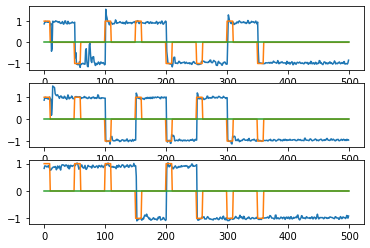

(64, 500, 220)


In [ ]:
from LIF_setup import  FlipFlop
hps_ = {'lrate':1e-02,'decay':0.8,
        'moment':0.9,'steps':1000,
        'norm':0.5,'use_data':False,
        'epochs':1,'n_regular':120,'adaptive':100}
rnn = FlipFlop(c_type='ALIF',l2=1e-05,decay_steps=1000,p = 0.2, **hps_) 
rnn.neurons = 220
rnn.activation = 'relu'
%matplotlib inline

import seaborn as sns
# rnn.train_network(10000, save=True)
# lis = rnn.reload_from_checkpoints('/content',create_model=True)
z = rnn.run_validation('/content',create_model = True)
# rnn.fixed_points()
# z,v,b = rnn.transition_graph('/content')

In [ ]:
# %matplotlib inline                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        %matplotlib inline
from plot_utils import plot_fps
from sklearn import manifold
import pylab
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
import os
import pickle
def restore(path):
	file = open(path,'rb')
	restore_data = file.read()
	file.close()

	hid= pickle.loads(restore_data,encoding='latin1')
	return(hid)
hid= restore(os.getcwd()+'/fps_saver/hiddens_.p')
z_ = hid[0]
v =  hid[1]
b =  hid[2]
psp = hid[3]
# v = np.stack(v,axis=1)
# b = np.stack(b,axis=1)
# print(psp.shape)
# print(v.shape)

fps = FixedPointStore(num_inits = 1,
				num_states= 1,
				num_inputs = 1)
dict_d = fps.restore(os.getcwd()+'/fps_saver/fixedPoint_unique.p')
fps.__dict__ = dict_d
# print(fps.qstar)

# plot_fps(fps,
#     np.array(z),
#     plot_batch_idx= range(30),
#     plot_start_time= 0,
#     is_lif= True,
#     plot_points= True)
# plt.show()
# z.shape
td = 20. 
dt =  1.
r_ = np.zeros((64,220))

func = lambda x ,z: x*pylab.exp(-dt/td) + z/td 
rs = np.zeros((64, 500, 220))
# for time_idx in range(500):
#   r = func(r, z_[:,time_idx,:])
#   rs[:,time_idx,:] = r
# r_ = fps.r
rs_ = np.zeros((64, 500, 220))
for time_idx in range(500):
    r_ = func(r_, z[:,time_idx,:])
    rs_[:,time_idx,:] = r_


# plt.plot(rs[:,:,10])
# plt.show()

FileNotFoundError: ignored

In [ ]:
plot_fps(fps,
        np.array(np.array(rs_[:,:,:100])),
        plot_batch_idx= range(64),
        plot_start_time= 10,
        plot_stop_time = 500,
        is_lif= True,
        plot_custom = False,
        cust_idx = [3,4], 
        cust_col = 'g',
        plot_points= False)
plt.show()
plot_fps(fps,
        np.array(np.array(z[:,:,:100])),
        plot_batch_idx= range(64),
        plot_start_time= 0,
        plot_stop_time = 500,
        is_lif= True,
        plot_custom = False,
        cust_idx = [3,4], 
        cust_col = 'g',
        plot_points= False)
plt.show()

ValueError: ignored

<Figure size 576x576 with 0 Axes>

In [ ]:
l!pip install nengo-extras


     |████████████████████████████████| 81kB 3.0MB/s 
     |████████████████████████████████| 532kB 4.9MB/s 


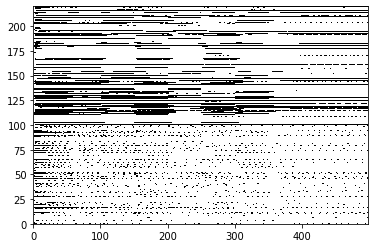

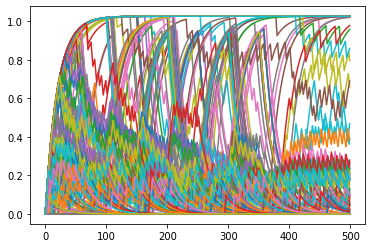

In [ ]:

from nengo_extras.plot_spikes import (
    cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance)
time = np.arange(z_.shape[1])
cmap={'cmap':'gray_r'}
plot_spikes(time,z[2,:,:],contrast_scale=1e-05,**cmap)
plt.show()
plt.plot(rs_[2,:,:])
plt.show()

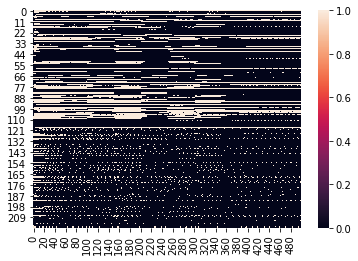

In [ ]:
import seaborn as sns 
sns.heatmap(z[63,:,:].T,)


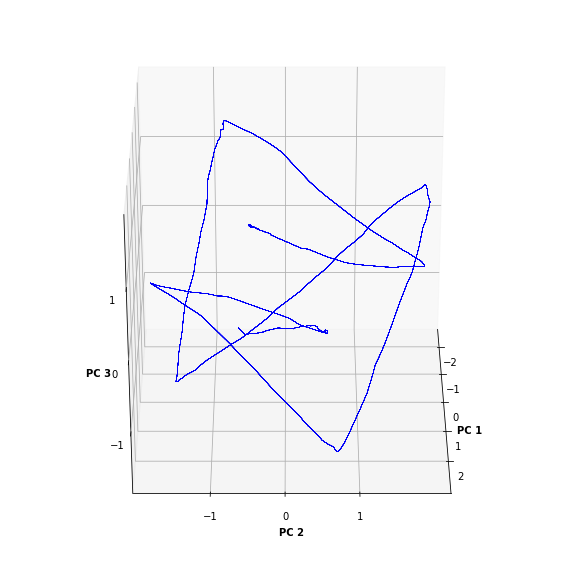

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pdb

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline 
import tf_utils

def plot_fps(fps,
	state_traj=None,
	plot_batch_idx=None,
	plot_start_time=0,
	plot_stop_time=None,
	mode_scale=0.25,
	fig=None,
	is_lif=False):

	'''Plots a visualization and analysis of the unique fixed points.

	1) Finds a low-dimensional subspace for visualization via PCA. If
	state_traj is provided, PCA is fit to [all of] those RNN state
	trajectories. Otherwise, PCA is fit to the identified unique fixed
	points. This subspace is 3-dimensional if the RNN state dimensionality
	is >= 3.

	2) Plots the PCA representation of the stable unique fixed points as
	black dots.

	3) Plots the PCA representation of the unstable unique fixed points as
	red dots.

	4) Plots the PCA representation of the modes of the Jacobian at each
	fixed point. By default, only unstable modes are plotted.

	5) (optional) Plots example RNN state trajectories as blue lines.

	Args:
		fps: a FixedPoints object. See FixedPoints.py.

		state_traj (optional): [n_batch x n_time x n_states] numpy
		array or LSTMStateTuple with .c and .h as
		[n_batch x n_time x n_states/2] numpy arrays. Contains example
		trials of RNN state trajectories.

		plot_batch_idx (optional): Indices specifying which trials in
		state_traj to plot on top of the fixed points. Default: plot all
		trials.

		plot_start_time (optional): int specifying the first timestep to
		plot in the example trials of state_traj. Default: 0.

		plot_stop_time (optional): int specifying the last timestep to
		plot in the example trials of stat_traj. Default: n_time.

		stop_time (optional):

		mode_scale (optional): Non-negative float specifying the scaling
		of the plotted eigenmodes. A value of 1.0 results in each mode
		plotted as a set of diametrically opposed line segments
		originating at a fixed point, with each segment's length specified
		by the magnitude of the corresponding eigenvalue.

		fig (optional): Matplotlib figure upon which to plot.

	Returns:
		None.
	'''

	FONT_WEIGHT = 'bold'
	if fig is None:
		FIG_WIDTH = 8 # inches
		FIG_HEIGHT = 8 # inches
		fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT),
			tight_layout=True)

	if state_traj is not None:
		if tf_utils.is_lstm(state_traj):
			state_traj_bxtxd = tf_utils.convert_from_LSTMStateTuple(
		state_traj)
		else:
			state_traj_bxtxd = state_traj

		[n_batch, n_time, n_states] = state_traj_bxtxd.shape

		# Ensure plot_start_time >= 0
		plot_start_time = np.max([plot_start_time, 0])

		if plot_stop_time is None:
			plot_stop_time = n_time
		else:
			# Ensure plot_stop_time <= n_time
			plot_stop_time = np.min([plot_stop_time, n_time])

		plot_time_idx = range(plot_start_time, plot_stop_time)

	n_inits = fps.num_inits
	n_states = 100#fps.num_states
	if n_states >= 3:
		pca = PCA(n_components=3)

		if state_traj is not None:
			state_traj_btxd = np.reshape(state_traj_bxtxd,
				(n_batch*n_time, n_states))
			pca.fit(state_traj_btxd)
		else:
			pca.fit(fps.xstar)

		ax = fig.add_subplot(111, projection='3d')
		# ax = Axes3D(fig)

		ax.set_xlabel('PC 1', fontweight=FONT_WEIGHT)
		ax.set_zlabel('PC 3', fontweight=FONT_WEIGHT)
		ax.set_ylabel('PC 2', fontweight=FONT_WEIGHT)

		# For generating figure in paper.md
		ax.set_xticks([-2, -1, 0, 1, 2])
		ax.set_yticks([-1, 0, 1])
		ax.set_zticks([-1, 0, 1])
	else:
		# For 1D or 0D networks (i.e., never)
		pca = None
		ax = fig.add_subplot(111)
		ax.xlabel('Hidden 1', fontweight=FONT_WEIGHT)
		if n_states == 2:
			ax.ylabel('Hidden 2', fontweight=FONT_WEIGHT)

	if state_traj is not None:
		if plot_batch_idx is None:
			plot_batch_idx = range(n_batch)

		for batch_idx in plot_batch_idx:
			x_idx = state_traj_bxtxd[batch_idx]

			if n_states >= 3:
				z_idx = pca.transform(x_idx[plot_time_idx, :])
			else:
				z_idx = x_idx[plot_time_idx, :]
			plot_123d(ax, z_idx, color='b', linewidth=0.2)

	# for init_idx in range(n_inits):
	# 	plot_fixed_point(
	# 		ax,
	# 		fps[init_idx],
	# 		# xstar[init_idx:(init_idx+1)],
	# 		# J_xstar[init_idx],
	# 		pca,
	# 		scale=mode_scale,
	# 		lif= is_lif)
	for angle in range(0, 360):
		ax.view_init(30, angle)
		plt.draw()
		plt.pause(.001)
		plt.show()
	# plt.ion()
	# plt.show()
	# plt.pause(1e-10)

def plot_123d(ax, z, **kwargs):
    '''Plots in 1D, 2D, or 3D.

    Args:
      ax: Matplotlib figure axis on which to plot everything.

      z: [n x n_states] numpy array containing data to be plotted,
      where n_states is 1, 2, or 3.

      any keyword arguments that can be passed to ax.plot(...).

    Returns:
      None.
    '''
    n_states = z.shape[1]
    if n_states ==3:
        ax.plot(z[:, 0], z[:, 1], z[:, 2], **kwargs)
    elif n_states == 2:
        ax.plot(z[:, 0], z[:, 1], **kwargs)
    elif n_states == 1:
        ax.plot(z, **kwargs)


plot_fps(fps,
    np.array(rs_[:,:,:100]),
    plot_batch_idx=range(64),
      plot_start_time=0,
      plot_stop_time = 500,
      is_lif=True)
plt.show()
# v_ = np.stack(v,axis=1)
# plt.plot(v[4,:100,:])
# plt.show()

# This section of the notebook is used for MDS plotting when all the networks are trained and reduced into graphs. 

An example for 3 bit flip flop is provided below. It needs transition graph file and the representation comparison matrix for plotting 2D MDS plot

In [ ]:
|
lis = rnn.reload_from_checkpoints('/content')
fps = FixedPointStore(num_inits = 1,
        num_states= 1,
        num_inputs = 1)
dict_d = fps.restore(os.getcwd()+'/fps_saver/fixedPoint_unique.p')
fps.__dict__ = dict_d
trans = np.zeros([fps.num_inits,fps.num_inits])

for y in range(20):
  print(y)
  fixed_points = fps.xstar

  fps_w_noise = fps.xstar+1e-01*np.random.randn(fixed_points.shape[0],fixed_points.shape[1])


  init_state = tf.convert_to_tensor(fps_w_noise, dtype=tf.float32)


  x = tf.placeholder(tf.float32, [fps.num_inits, rnn.time, rnn.bits], name='input_placeholder')

  if rnn.c_type =='LSTM':
    init_state = rnn.fps.convert_to_lstm_tuples(init_state)
    rnn_outs= rnn.unroll_LSTM(rnn.cell, x,initial_state=init_state)
  else:
    rnn_outs,_= tf.nn.dynamic_rnn(rnn.cell,x,initial_state=init_state)

  zero_inpt = np.zeros((fps.num_inits, rnn.time, rnn.bits))
  hids = rnn.sess.run(rnn_outs, feed_dict={x:zero_inpt})
  
  if rnn.c_type =='LSTM':
    hids = rnn.fps.convert_from_lstm_tuples(hids)
  for l in range(fps.num_inits):
    for j in range(fps.num_inits):
      index = slice(j,j+1)
      inits_ = fixed_points[index]

      if np.linalg.norm(inits_-hids[l,99,:])<0.01:
        trans[l,j]+=1
import seaborn as sns 
sns.heatmap(trans,cmap='rainbow',vmin=0)


In [ ]:

def restore(path):
	file = open(path,'rb')
	restore_data = file.read()
	file.close()

	hid= pickle.loads(restore_data,encoding='latin1')
	return(hid)
a = restore('/content/transit.p')
m = a
import seaborn as sns 
sns.heatmap(a,cmap='rainbow')

temp1 = []
temp2 = []
temp3 = []
temp4 = []


ind  = []
for i in range(a.shape[0]):
  if np.count_nonzero(a[i]) ==1:
    temp1.append(a[i])
  elif np.count_nonzero(a[i])==2:
    temp2.append(a[i])
  elif np.count_nonzero(a[i])==4:
    temp3.append(a[i])
  else:
    temp4.append(a[i])
glf = np.concatenate((np.array(temp1),np.array(temp2),np.array(temp3),np.array(temp4)))
for i in range(glf.shape[1]):
  if np.count_nonzero(glf[i]) ==1:
    ind.append(glf[:,np.argmax(glf[i])])
y = glf.shape[0]-len(ind)
final = np.concatenate((np.array(ind).T,np.zeros((glf.shape[0],y))),axis=1)
sns.heatmap(final,cmap='rainbow')

FileNotFoundError: ignored

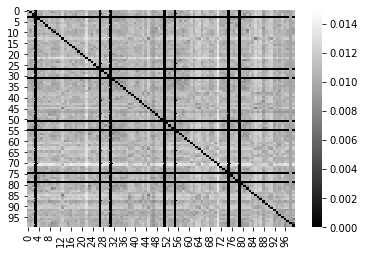

299070.55785717187

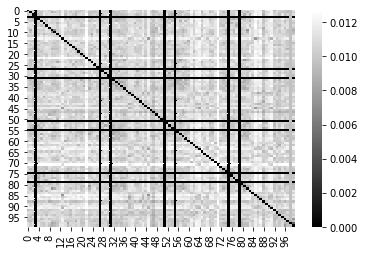

In [ ]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt

def restore(path):
	file = open(path,'rb')
	restore_data = file.read()
	file.close()

	hid= pickle.loads(restore_data,encoding='latin1')
	return(hid)
m = restore('/content/distance_matrix_200.p')
m = m
import seaborn as sns
ax_p = []
ax_ = []
sns.heatmap(m/np.linalg.norm(m),cmap='gist_gray')
plt.savefig('dist_fps.png',dpi=400)
plt.show()
for i in range(m.shape[0]):
	if np.sum(m[i,:]) == 0.0:
		ax_p.append(i)
	a = np.delete(m,ax_p,axis=0)
	a = np.delete(a,ax_p,axis=1)

sns.heatmap(a/np.linalg.norm(a),cmap='gray',robust=True)

np.linalg.norm(a)

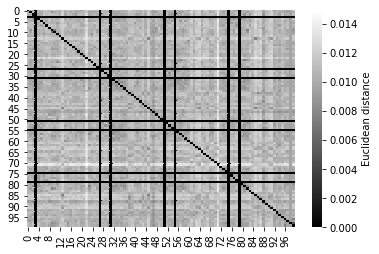

In [ ]:
ax_p = np.where(np.sum(m,axis=0)==0)
temp = m
temp[ax_p,:] = 0
sns.heatmap(temp/np.linalg.norm(temp),cmap='gist_gray',cbar_kws={'label':'Euclidean distance'})
plt.savefig('dist_fps.png',dpi=400)
plt.show()

In [ ]:
def hps_array():
    arch  = ['Vanilla', 'UGRNN', 'GRU', 'LSTM']
    activ = ['tanh' , 'relu']
    units = [64, 128, 256 ]
    l2_norm = [1e-5, 1e-4, 1e-3, 1e-2]
    hps_dict = {'arch':arch,
                'activ':activ,
                'units':units,
                'l2_norm':l2_norm}

    hps_array = []
    # adp_lr = {'initial_rate': 1.0, 'min_rate': 1e-5}
    for i in arch:
        for j in activ:
            for k in units:
                for l in l2_norm:
                    hps_array.append({'arch':i,
                                    'activ':j,
                                    'units':k,
                                    'l2_norm':l,
                                    'seed':400})
    hps_array.append('rate_200')
    hps_array.append('rate_250')
    hps_array.append('rate_200_no_dale')
    hps_array.append('rate_250_no_dale')
    # hps_array.append('spike')
    # hps_array.append('spike_no_dale')

    return hps_array  


In [ ]:
hps_array()[3]

{'activ': 'tanh', 'arch': 'Vanilla', 'l2_norm': 0.01, 'seed': 400, 'units': 64}

(100,)


/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


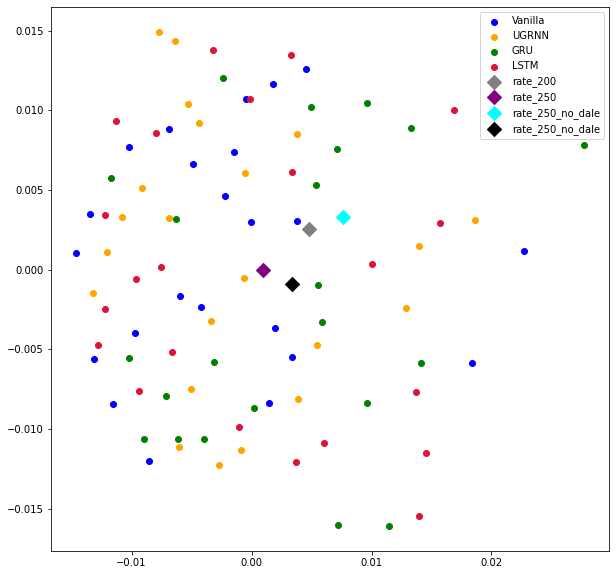

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler
def restore(path):
	file = open(path,'rb')
	restore_data = file.read()
	file.close()

	hid= pickle.loads(restore_data,encoding='latin1')
	return(hid)

mask = []
mask_rec = []
mask_N = []

for i in hps_array():
    # print(i)
    if type(i) != str: 
        if i['arch'] == 'Vanilla':
            mask.append(0)
        if i['arch']=='UGRNN':
            mask.append(1)
        if i['arch']=='GRU':
            mask.append(2)
        if i['arch']=='LSTM':
            mask.append(3)
    elif i=='rate_200':
        mask.append(4)
    elif i=='rate_250':
        mask.append(5)
    elif i=='rate_200_no_dale':
        mask.append(6)
    elif i=='rate_250_no_dale':
        mask.append(7)

for i in hps_array():
    if type(i) != str:
        if i['activ'] == 'relu':
            mask_rec.append(0)
        if i['activ'] == 'tanh':
            mask_rec.append(1)
for i in hps_array():
    if type(i) != str:
        if i['units'] == 256:
            mask_N.append(0)
        if i['units'] == 128:
            mask_N.append(1)
        if i['units'] == 64:
            mask_N.append(2)

mask = np.array(mask)
print(mask.shape)
mask_rec= np.array(mask_rec)
m = restore('/content/distance_matrix_200.p')[:,:]
ax_p = np.where(np.sum(m,axis=0)==0)
temp = m
temp[ax_p,:] = 0
m = temp
import seaborn as sns
ax = []
for i in range(m.shape[0]):
  if np.sum(m[i,:]) == 0.0:
    ax.append(i)
  data = np.delete(m,ax,axis=0)
  data = np.delete(data,ax,axis=1)
  mask_ = np.delete(mask,ax,axis=0)
  mask_rec_ = np.delete(mask_rec,ax,axis=0)
  mask_N_ = np.delete(mask_N,ax,axis=0)
X = data/np.linalg.norm(data)
mds = MDS(2,random_state=0)
X_2d = mds.fit_transform(X)
colors = ['blue','orange','green','crimson','gray','purple','cyan','black']
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('font', size=10)
fig = plt.figure()
ax_ = plt.subplot(111)
names = ['Vanilla','UGRNN','GRU','LSTM','rate_200','rate_250','rate_250_no_dale','rate_250_no_dale']
for i in np.unique(mask_):

    subset = X_2d[mask_ == i]
    x = [row[0] for row in subset]
    y = [row[1] for row in subset]

    if i >3 :
        ax_.scatter(x,y,s=100.,c=colors[i],marker='D',label=names[i])
        # if i==4:
        #     ax_.annotate('rate 200',(x[0],y[0]),xytext = (6000,0),arrowprops={'arrowstyle':'<-'})
        # if i==5:
        #     ax_.annotate('rate 250',(x[0],y[0]),xytext = (6000,1000),arrowprops={'arrowstyle':'<-'})
        
        ax_.legend()
    else:
        
        ax_.scatter(x,y,c=colors[i],label=names[i])

        ax_.legend()
# ax_.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig('fps_arch_rate.png',dpi=400)
plt.show()


(89, 89)


/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


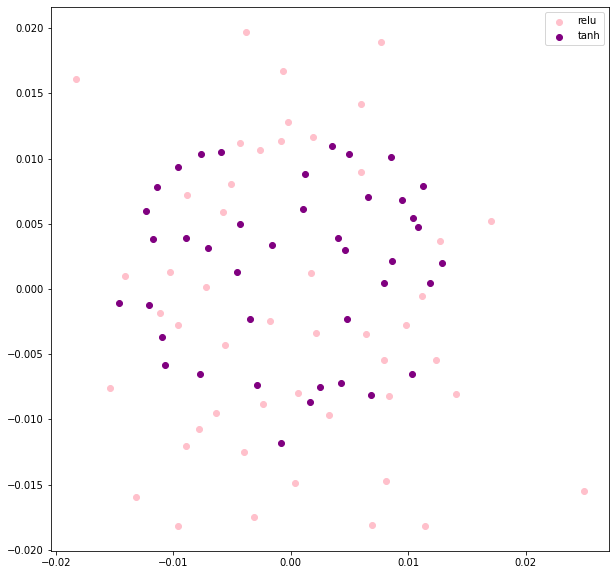

In [ ]:
X = data/np.linalg.norm(data)
X = X[:,:]
print(X.shape)
mds = MDS(2,random_state=0)
X_2d = mds.fit_transform(X)

colors = ['pink','purple']
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('font', size=10)
names = ['relu','tanh']
for i in np.unique(mask_rec_):

  subset = X_2d[mask_rec_ == i]
  x = [row[0] for row in subset]
  y = [row[1] for row in subset]
  
  plt.scatter(x,y,c=colors[i],label=names[i])
  plt.legend()
plt.savefig('fps_act.png',dpi=400)
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('font', size=10)
plt.show()

In [ ]:
X = data/np.linalg.norm(data)
X = X[:-4,:-4]
mds = MDS(2,random_state=0)
X_2d = mds.fit_transform(X)
colors = ['red','green','blue']
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('font', size=10)
names = ['256','128','64']
for i in np.unique(mask_N_):

  subset = X_2d[mask_N_ == i]
  x = [row[0] for row in subset]
  y = [row[1] for row in subset]
  
  plt.scatter(x,y,c=colors[i],label=names[i])
  plt.legend()
plt.savefig('fps_N.pdf',dpi=400)
plt.show()


NameError: ignored

In [ ]:
def hps_array():
    arch  = ['Vanilla', 'UGRNN', 'GRU', 'LSTM']
    activ = ['tanh' , 'relu']
    units = [64, 128, 256 ]
    l2_norm = [1e-5, 1e-4, 1e-3, 1e-2]
    hps_dict = {'arch':arch,
                'activ':activ,
                'units':units,
                'l2_norm':l2_norm}

    hps_array = []
    # adp_lr = {'initial_rate': 1.0, 'min_rate': 1e-5}
    for i in arch:
        for j in activ:
            for k in units:
                for l in l2_norm:
                    hps_array.append({'arch':i,
                                    'activ':j,
                                    'units':k,
                                    'l2_norm':l,
                                    'seed':400})
    hps_array.append('rate_200')
    hps_array.append('rate_250')
    hps_array.append('rate_200_no_dale')
    hps_array.append('rate_250_no_dale')
    hps_array.append('spike')
    hps_array.append('spike_no_dale')

    return hps_array  


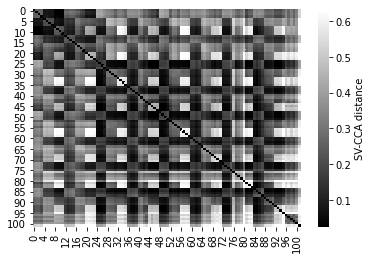

In [ ]:
def restore(path):
	file = open(path,'rb')
	restore_data = file.read()
	file.close()

	hid= pickle.loads(restore_data,encoding='latin1')
	return(hid)
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns 
import pickle
# a = restore('/content/svcca_matrix.p')
# b = restore('/content/svcca_matrix_par.p')
# d = restore('/content/svcca_matrix_par2.p')
# e = restore('/content/svcca_matrix_par3.p')
# f = restore('/content/svcca_matrix_spk.p')
# g = restore('/content/svcca_matrix_spk1.p')
# f = f+g
# c = np.zeros_like(f)
# # c = np.zeros_like(e)
# c[:a.shape[0],:a.shape[1]] =a 
# c[:b.shape[0],:b.shape[1]]= c[:b.shape[0],:b.shape[1]]+b
# c[:b.shape[0],:b.shape[1]]=c[:b.shape[0],:b.shape[1]]+d
# c[:b.shape[0],:b.shape[1]]=c[:b.shape[0],:b.shape[1]]+e
# c+=f
# c+=f.T
# sns.heatmap(c,cmap='Greys_r',center=.5)

a = restore('/content/svcca_matrix_comp1.p')
b = restore('/content/svcca_matrix_comp2.p')
c = restore('/content/svcca_matrix_comp3.p')
d = restore('/content/svcca_matrix_comp4.p')
e = a+b+c+d
f = e+e.T
f = f
# fig, ax = plt.plot()
sns.heatmap(f,cmap='gray',robust=True,cbar_kws={'label':'SV-CCA distance'})
# f.shape
plt.savefig('dist_matrix_svcca.png',dpi=400)
plt.show()


In [ ]:
print(c.shape)
print(c[98,2])

(102, 102)
0.0


/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


(96, 2)


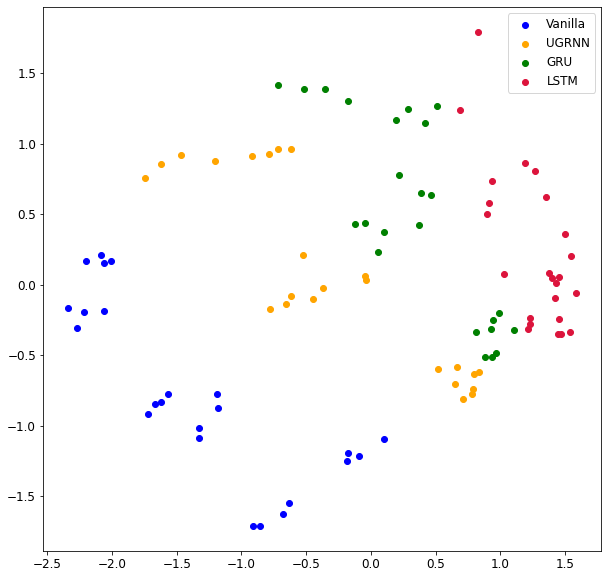

In [ ]:
import seaborn as sns 
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler
def restore(path):
	file = open(path,'rb')
	restore_data = file.read()
	file.close()

	hid= pickle.loads(restore_data,encoding='latin1')
	return(hid)

mask = []
mask_rec = []
mask_N = []
for i in hps_array():
    if type(i) != str: 
        if i['arch'] == 'Vanilla':
            mask.append(0)
        if i['arch']=='UGRNN':
            mask.append(1)
        if i['arch']=='GRU':
            mask.append(2)
        if i['arch']=='LSTM':
            mask.append(3)
    # elif i=='rate_200':
    #     mask.append(4)
    # elif i=='rate_250':
    #     mask.append(5)
    # elif i=='rate_200_no_dale':
    #     mask.append(6)
    # elif i=='rate_250_no_dale':
    #     mask.append(7)
    # elif i=='spike':
    #     mask.append(8)
    # elif i=='spike_no_dale':
    #     mask.append(9)        
for i in hps_array():
    if type(i) != str:
        if i['activ'] == 'relu':
            mask_rec.append(0)
        if i['activ'] == 'tanh':
            mask_rec.append(1)
for i in hps_array():
    if type(i) != str:
        if i['units'] == 256:
            mask_N.append(0)
        if i['units'] == 128:
            mask_N.append(1)
        if i['units'] == 64:
            mask_N.append(2)
mask = np.array(mask)
mask_rec_= np.array(mask_rec)
m =e[:-6,:-6] 

import seaborn as sns
ax = []
mask_ = mask
X = m
mds = MDS(2,random_state=np.random.RandomState(400))
X_2d = mds.fit_transform(X)
print(X_2d.shape)
colors = ['blue','orange','green','crimson','gray','purple','cyan','black','orange','pink']
plt.rcParams['figure.figsize'] = [10,10]
plt.rc('font', size=12)
fig = plt.figure()
ax_ = plt.subplot(111)
names = ['Vanilla','UGRNN','GRU','LSTM',
         'rate_200',
         'rate_250','rate_200_no_dale',
         'rate_250_no_dale',
         'LIF',
         'LIF_no_dale']
for i in np.unique(mask_):

    subset = X_2d[mask_ == i]
    x = [row[0] for row in subset]
    y = [row[1] for row in subset]
    if i >3 :
        ax_.scatter(x,y,s=100.,c=colors[i],marker='D',label=names[i])

        ax_.legend()
    else:
        
        ax_.scatter(x,y,c=colors[i],label=names[i])

        ax_.legend()
plt.savefig('svcca_arch.png',dpi=400)
plt.show()



/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


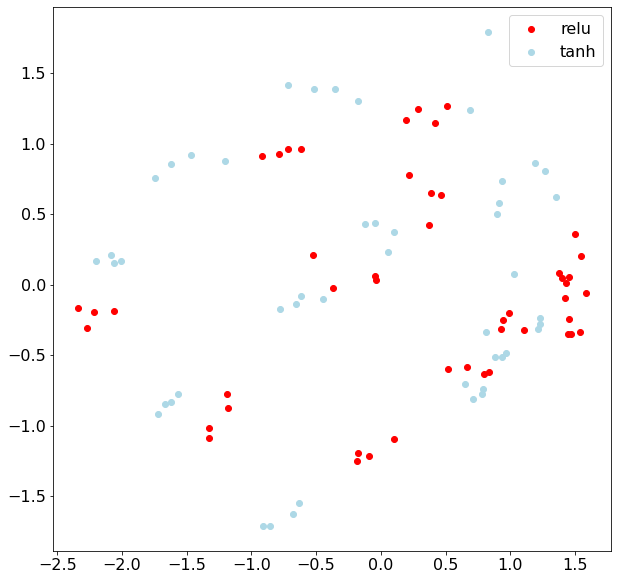

In [ ]:
X = m

mds = MDS(2,random_state=np.random.RandomState(400))
X_2d = mds.fit_transform(X)

colors = ['red','lightblue']
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('font', size=16)
names = ['relu','tanh']
for i in np.unique(mask_rec_):

  subset = X_2d[mask_rec_ == i]
  x = [row[0] for row in subset]
  y = [row[1] for row in subset]
  
  plt.scatter(x,y,c=colors[i],label=names[i])
  plt.legend()
plt.savefig('svcca_activ.png',dpi=400)
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


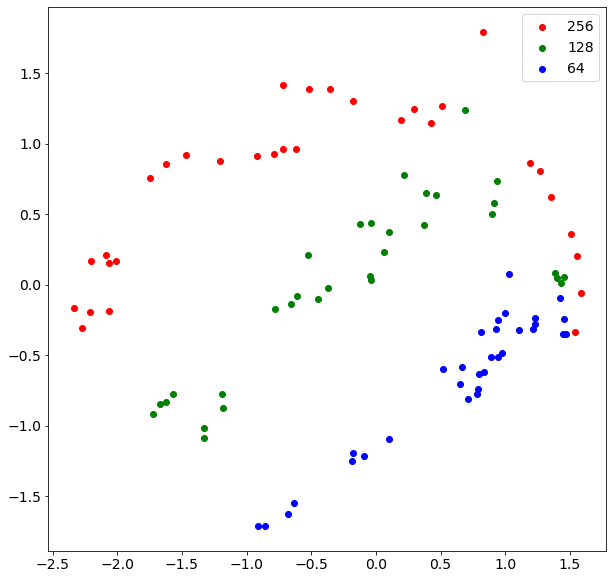

In [ ]:
X = m
mds = MDS(2,random_state=np.random.RandomState(400))
X_2d = mds.fit_transform(X)
colors = ['red','green','blue']
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('font', size=14)
names = ['256','128','64']
for i in np.unique(mask_N):

  subset = X_2d[mask_N == i]
  x = [row[0] for row in subset]
  y = [row[1] for row in subset]
  
  plt.scatter(x,y,c=colors[i],label=names[i])
  plt.legend()

plt.savefig('svcca_N.png',dpi=400)
plt.show()


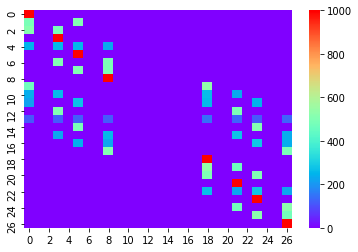

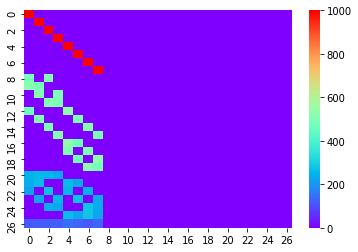

In [ ]:
import pickle 
import seaborn as sns 
def restore(path):
	file = open(path,'rb')
	restore_data = file.read()
	file.close()
	hid= pickle.loads(restore_data,encoding='latin1')
	return(hid)
import matplotlib.pyplot as plt

def order_fps(rnn):

	trans = rnn
	temp1 = []
	temp2 = []
	temp3 = []
	temp4 = []
	ind  = []
	
	for i in range(trans.shape[0]):
	  if np.count_nonzero(trans[i]) ==1:
	    temp1.append(trans[i])
	  elif np.count_nonzero(trans[i])==2:
	    temp2.append(trans[i])
	  elif np.count_nonzero(trans[i])==4:
	    temp3.append(trans[i])
	  else:
	    temp4.append(trans[i])

	glf = np.concatenate((np.array(temp1),np.array(temp2),np.array(temp3),np.array(temp4)))
	for i in range(glf.shape[1]):
	  if np.count_nonzero(glf[i]) ==1:
	    ind.append(glf[:,np.argmax(glf[i])])
	y = glf.shape[0]-len(ind)
	final = np.concatenate((np.array(ind).T,np.zeros((glf.shape[0],y))),axis=1)
	return final
import numpy as np
a = restore('/content/transit.p')
sns.heatmap(a,cmap='rainbow')
# plt.rcParams['figure.figsize'] = [10,8]
plt.savefig('trasit.png',dpi=400)
plt.show()
b=order_fps(a)

sns.heatmap(b,cmap='rainbow')
plt.savefig('trasit_ordered.png',dpi=400)
plt.show()

In [ ]:
%tensorflow_version 1.x
%matplotlib inline 
!python main.py --gpu 0 --gpu_frac 0.20 --n_trials 5000 --mode test --N 200 --P_inh 0.20 --som_N 0 --apply_dale True --gain 1.5 --task flip --act sigmoid --loss_fn l2 --decay_taus 10 --output_dir ../

TensorFlow 1.x selected.
No display found. Using non-interactive Agg backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
P_rec set to 0.2
Intialized the network...

Synaptic decay time-constants will not get updated!

Constructed the TF graph...



2020-09-19 20:51:41.524184: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2020-09-19 20:51:41.524487: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2c18a00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-09-19 20:51:41.524519: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-09-19 20:51:41.527319: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1


(1000, 64, 3)

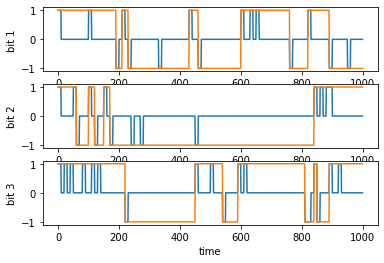

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(400)
def flip_flop():
    time = 100
    batch = 64
    bit = 3
    unsigned_inp = np.random.binomial(1,0.2,[batch,time,bit])
    unsigned_out = 2*np.random.binomial(1,0.5,[batch,time,bit]) -1 



    inputs = np.multiply(unsigned_inp,unsigned_out)
    inputs[:,0,:] = 1
    inputs = np.repeat(inputs,10,axis=1)

    output = np.zeros_like(inputs)
    for trial_idx in range(batch):
        for bit_idx in range(bit):
            input_ = np.squeeze(inputs[trial_idx,:, bit_idx])
            t_flip = np.where(input_ != 0)
            for flip_idx in range(np.size(t_flip)):
                # Get the time of the next flip
                t_flip_i = t_flip[0][flip_idx]

                '''Set the output to the sign of the flip for the
                remainder of the trial. Future flips will overwrite future
                output'''
                output[trial_idx, t_flip_i:, bit_idx] = \
                    inputs[trial_idx, t_flip_i, bit_idx]

    return({'inputs':inputs ,'outputs': output})
a = flip_flop()
fig,ax = plt.subplots(3)
m = np.stack(a['inputs'],axis=1)
n = np.stack(a['outputs'],axis=1)
# print(np.array(t_o).shape)
ax[0].plot(np.array(m)[:,0,0])
ax[0].plot(np.array(n)[:,0,0])
# ax[0].plot(np.array(t_o)[:,0,0])
ax[0].set_xlabel('time')
ax[0].set_ylabel('bit 1')

ax[1].plot(np.array(m)[:,0,1])
ax[1].plot(np.array(n)[:,0,1])
# ax[1].plot(np.array(t_o)[:,0,1])
ax[1].set_xlabel('time')
ax[1].set_ylabel('bit 2')

ax[2].plot(np.array(m)[:,0,2])
ax[2].plot(np.array(n)[:,0,2])
# ax[2].plot(np.array(t_o)[:,0,2])
ax[2].set_xlabel('time')
ax[2].set_ylabel('bit 3')
m.shape

(500, 64, 3)

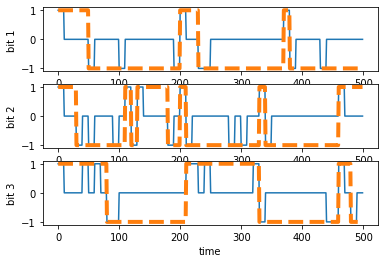

In [ ]:

settings = {
        'T': 500, # trial duration (in steps)
        'stim_on': 50, # input stim onset (in steps)
        'stim_dur': 200, # input stim duration (in steps)
        'DeltaT': 1, # sampling rate
        'taus': 10, # decay time-constants (in steps)
        'task': 'flip', # task name
        'bits' : 3,
        'batch': 64
        }
import numpy as np
import matplotlib.pyplot as plt  
np.random.seed(400)

def generate_flip_flop_trial(settings):


    
    trial_info = {'neural_input': np.zeros([settings['T'],settings['batch'], settings['bits']]),
                  'desired_output':np.zeros([settings['T'],settings['batch'], settings['bits']])}    



    unsigned_inp = np.random.binomial(1,0.2,[settings['T']//10,settings['batch'], settings['bits']])
    unsigned_out = 2*np.random.binomial(1,0.5,[settings['T']//10,settings['batch'], settings['bits']]) -1 


  
    inputs = unsigned_inp
    inputs = np.multiply(unsigned_inp,unsigned_out)
    inputs[0,:] = 1.0

    inputs = np.repeat(inputs,10,axis=0)

    trial_info['neural_input'] = inputs
    # trial_info['neural_input'] = 0.5*trial_info['neural_input']
    output = np.zeros_like(inputs)
    for trial_idx in range(settings['batch'] ):
        for bit_idx in range(settings['bits']):
            input_ = np.squeeze(inputs[:,trial_idx,bit_idx])
            t_flip = np.where(input_ != 0)
            for flip_idx in range(np.size(t_flip)):
                # Get the time of the next flip
                t_flip_i = t_flip[0][flip_idx]

                '''Set the output to the sign of the flip for the
                remainder of the trial. Future flips will overwrite future
                output'''
                output[t_flip_i:,trial_idx, bit_idx] = \
                    inputs[t_flip_i,trial_idx,  bit_idx]

    trial_info['desired_output'] = output
    # trial_info['desired_output'] = 0.5*trial_info['desired_output']

    return trial_info
b = generate_flip_flop_trial(settings)
fig,ax = plt.subplots(3)
# print(np.array(t_o).shape)
ax[0].plot(np.array(b['neural_input'])[:,0,0])
ax[0].plot(np.array(b['desired_output'][:,0,0]),linestyle='dashed',linewidth=4)
# ax[0].plot(np.array(t_o)[:,0,0])
ax[0].set_xlabel('time')
ax[0].set_ylabel('bit 1')

ax[1].plot(np.array(b['neural_input'])[:,0,1])
ax[1].plot(np.array(b['desired_output'][:,0,1]),linestyle='dashed',linewidth=4)
# ax[1].plot(np.array(t_o)[:,0,1])
ax[1].set_xlabel('time')
ax[1].set_ylabel('bit 2')

ax[2].plot(np.array(b['neural_input'])[:,0,2])
ax[2].plot(np.array(b['desired_output'][:,0,2]),linestyle='dashed',linewidth=4)
# ax[2].plot(np.array(t_o)[:,0,2])
ax[2].set_xlabel('time')
ax[2].set_ylabel('bit 3')
b['neural_input'].shape
# b['desired_output'].shape

Text(0, 0.5, 'bit 3')

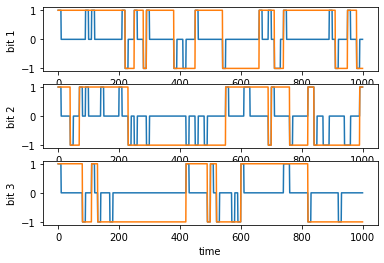

In [ ]:

settings = {
        'T': 1000, # trial duration (in steps)
        'stim_on': 50, # input stim onset (in steps)
        'stim_dur': 200, # input stim duration (in steps)
        'DeltaT': 1, # sampling rate
        'taus': 10, # decay time-constants (in steps)
        'task': 'flip', # task name
        'bits' : 3,
        'batch': 64
        }
np.random.seed(500)
def generate_flip_flop_trial(settings):


    
    trial_info = {'neural_input': np.zeros([settings['T'],settings['batch'], settings['bits']]),
                  'desired_output':np.zeros([settings['T'],settings['batch'], settings['bits']])}    



    unsigned_inp = np.random.binomial(1,0.2,[settings['T']//10,settings['batch'], settings['bits']])
    unsigned_out = 2*np.random.binomial(1,0.5,[settings['T']//10,settings['batch'], settings['bits']]) -1 


  
    inputs = unsigned_inp
    inputs = np.multiply(unsigned_inp,unsigned_out)
    inputs[0,:] = 1.0

    inputs = np.repeat(inputs,10,axis=0)

    trial_info['neural_input'] = inputs
    # trial_info['neural_input'] = 0.5*trial_info['neural_input']
    output = np.zeros_like(inputs)
    for trial_idx in range(settings['batch'] ):
        for bit_idx in range(settings['bits']):
            input_ = np.squeeze(inputs[:,trial_idx,bit_idx])
            t_flip = np.where(input_ != 0)
            for flip_idx in range(np.size(t_flip)):
                # Get the time of the next flip
                t_flip_i = t_flip[0][flip_idx]

                '''Set the output to the sign of the flip for the
                remainder of the trial. Future flips will overwrite future
                output'''
                output[t_flip_i:,trial_idx, bit_idx] = \
                    inputs[t_flip_i,trial_idx,  bit_idx]

    trial_info['desired_output'] = output
    # trial_info['desired_output'] = 0.5*trial_info['desired_output']

    return trial_info
b = generate_flip_flop_trial(settings)
fig,ax = plt.subplots(3)
# print(np.array(t_o).shape)
ax[0].plot(np.array(b['neural_input'])[:,0,0])
ax[0].plot(np.array(b['desired_output'][:,0,0]))
# ax[0].plot(np.array(t_o)[:,0,0])
ax[0].set_xlabel('time')
ax[0].set_ylabel('bit 1')

ax[1].plot(np.array(b['neural_input'])[:,0,1])
ax[1].plot(np.array(b['desired_output'][:,0,1]))
# ax[1].plot(np.array(t_o)[:,0,1])
ax[1].set_xlabel('time')
ax[1].set_ylabel('bit 2')

ax[2].plot(np.array(b['neural_input'])[:,0,2])
ax[2].plot(np.array(b['desired_output'][:,0,2]))
# ax[2].plot(np.array(t_o)[:,0,2])
ax[2].set_xlabel('time')
ax[2].set_ylabel('bit 3')

In [ ]:
l = b>1

e = []
for i in range(np.shape(l)[0]):
    for j in range(np.shape(l)[1]):
        if l[i,j]==True:
            e.append((i,j))


In [ ]:
G.edges

EdgeView([(0, 0), (0, 8), (0, 9), (0, 11), (0, 20), (0, 21), (0, 22), (0, 26), (1, 1), (1, 8), (1, 10), (1, 14), (1, 20), (1, 22), (1, 24), (1, 26), (2, 2), (2, 9), (2, 12), (2, 13), (2, 20), (2, 21), (2, 23), (2, 26), (3, 3), (3, 10), (3, 12), (3, 15), (3, 20), (3, 23), (3, 24), (3, 26), (4, 4), (4, 11), (4, 16), (4, 17), (4, 21), (4, 22), (4, 25), (4, 26), (5, 5), (5, 14), (5, 17), (5, 18), (5, 22), (5, 24), (5, 25), (5, 26), (6, 6), (6, 13), (6, 16), (6, 19), (6, 21), (6, 23), (6, 25), (6, 26), (7, 7), (7, 15), (7, 18), (7, 19), (7, 23), (7, 24), (7, 25), (7, 26)])

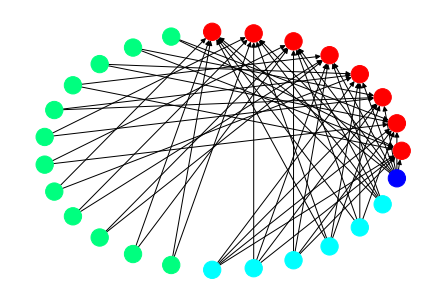

In [ ]:
import plotly.graph_objects as go

import networkx as nx
import numpy as np
G = nx.DiGraph(l,) 
color_map = []
for node in G:
    if node<8:
        color_map.append('red')
    elif node>=8 and node<20:
        color_map.append('springgreen')
    elif node>19 and node<26:
        color_map.append('cyan')
    else:
        color_map.append('blue')        
nx.draw_circular(G, node_color=color_map)
plt.show()